In [1]:
%pylab inline

#from __future__ import division

import timeit

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

print pd.__version__

Populating the interactive namespace from numpy and matplotlib
0.24.1


# Load data

In [2]:
# Data for each store for each day. Nrows ~ Nstores*Ndays
df_train = pd.read_csv('train_clean.csv', low_memory=False)
df_test = pd.read_csv('test_clean.csv', low_memory=False)

In [3]:
###### Columns to use for target and features #######

# Drop these because you only need k-1 features:
# 'StateHoliday_0', 'StoreType_a', 'Assortment_a'

target = 'Sales'

features = [
    'MeanSales', 
    'Open',
    'DayOfWeek', 'DayOfMonth', 'Month', 
    'CompetitionOpen', 'CompetitionDistance', 
    'Promo', 'MonthsSinceCoupons', 
    'SchoolHoliday', 
    'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 
    'StoreType_b', 'StoreType_c', 'StoreType_d', 
    'Assortment_b', 'Assortment_c'
]

In [4]:
df_train[features].sample(10)

,MeanSales,Open,DayOfWeek,DayOfMonth,Month,CompetitionOpen,CompetitionDistance,Promo,MonthsSinceCoupons,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
127535,4570.229299,1,2,18,11,1,1540.0,0,2,0,0,0,0,0,1,0,0,1
171252,5907.321900,1,4,9,7,1,1470.0,0,0,0,0,0,0,0,0,0,0,0
910078,3560.788747,1,1,17,2,1,780.0,1,0,0,0,0,0,0,0,0,0,0
115180,5381.677282,1,3,16,1,0,3370.0,0,2,0,0,0,0,0,0,1,0,0
997252,6904.761146,0,7,2,6,1,10450.0,0,-1,0,0,0,0,0,1,0,0,1
211582,9156.405520,1,2,20,1,1,4370.0,0,-1,0,0,0,0,0,0,1,0,0
254074,5169.680467,0,4,1,5,1,18640.0,1,2,0,1,0,0,0,0,1,0,1
814209,6931.208068,1,3,10,6,1,190.0,0,-1,0,0,0,0,0,0,0,0,0
30227,6976.813163,1,5,3,5,1,1320.0,1,-1,0,0,0,0,0,0,0,0,1
780025,5944.401274,1,6,18,1,1,3020.0,0,-1,0,0,0,0,0,0,0,0,0


In [5]:
df_test[features].sample(10)

,MeanSales,Open,DayOfWeek,DayOfMonth,Month,CompetitionOpen,CompetitionDistance,Promo,MonthsSinceCoupons,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
6975,5907.321900,1.0,3,2,9,1,1470.0,1,2,1,0,0,0,0,0,0,0,0
16493,4417.384289,1.0,3,19,8,1,1510.0,1,-1,1,0,0,0,0,0,0,0,1
37778,7852.531847,1.0,2,15,9,1,450.0,1,0,0,0,0,0,0,1,0,0,0
34646,6078.120053,1.0,1,10,8,1,15700.0,0,1,1,0,0,0,0,0,0,0,0
17105,5040.073248,1.0,1,31,8,1,4160.0,1,-1,0,0,0,0,0,0,0,0,0
24077,5244.336412,1.0,3,19,8,1,1420.0,1,1,1,0,0,0,0,0,0,0,0
30595,3744.244063,1.0,6,29,8,1,380.0,0,1,0,0,0,0,0,0,0,0,0
24232,6641.935244,1.0,6,8,8,1,960.0,0,0,0,0,0,0,0,0,1,0,1
23569,4899.651715,1.0,3,16,9,1,10170.0,1,-1,0,0,0,0,0,0,1,0,0
13938,5230.382166,0.0,7,30,8,1,2140.0,0,-1,0,0,0,0,0,0,0,0,1


# Split data into train and validation sets, then do regression

In [6]:
# TODO: This should take the 'Open' column and exclude that row if 'Open'==0. 
# Some stores might not have sales even if they're open, so you can't just use y!=0 as a mask.

def calculate_rmspe(y, y_pred):
    """
    Parameters
    ----------
    y : Total sales for each store on each day (in EUR).
    y_pred : Predicted values of y.
    """
    # Don't count samples where the true sales=0
    mask = y!=0
    n = np.sum(mask)
    
    frac_square = ((y[mask]-y_pred[mask])/y[mask])**2
    rmspe = np.sqrt(np.sum(frac_square)/n)
    
    return rmspe

In [7]:
print df_train['Date'].min(), df_train['Date'].max()
print df_test['Date'].min(), df_test['Date'].max()

2013-01-01 2015-07-31
2015-08-01 2015-09-17


In [12]:
# Train on all but the last 2 months of the training set
df_train_start = df_train[df_train['Date']<'2015-06-01'].copy()

# Validate on the last 2 months of the training set
df_val = df_train[df_train['Date']>='2015-06-01'].copy()

# Feature matrices
X_train = df_train_start[features].values
X_val = df_val[features].values

# Target vectors
y_train = df_train_start[target].values
y_val = df_val[target].values

In [14]:
print X_train.shape, y_train.shape
print X_val.shape, y_val.shape
print X_test.shape

(949194, 18) (949194,)
(68015, 18) (68015,)
(41088, 18)


In [15]:
import sklearn
sklearn.__version__

'0.20.2'

In [16]:
from sklearn import ensemble

n_estimators=20
#max_depth = 10
#min_samples_leaf = 100
min_samples_split = 2

err_array = []
for max_depth in [5, 8, 15, 25, 30]:
    for min_samples_leaf in [1, 2, 5, 10, 15, 100, 200, 500]:
        reg = ensemble.RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, 
            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
            max_features='sqrt', 
            n_jobs=-1, random_state=1)

        reg.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = reg.predict(X_train)
        y_val_pred = reg.predict(X_val)
        
        # Compare to true values
        err_train = calculate_rmspe(y_train, y_train_pred)
        err_val = calculate_rmspe(y_val, y_val_pred)
        err = [max_depth, min_samples_leaf, err_train, err_val]
        print err
        err_array.append(err)
        
err_array = np.array(err_array)

[5, 1, 0.4408584374677863, 0.3614903943764188]
[5, 2, 0.4408565297035667, 0.3614903746367038]
[5, 5, 0.4419136923701692, 0.36230508301252523]
[5, 10, 0.4414595290804783, 0.3620115579039612]
[5, 15, 0.44350819194819224, 0.36401204098810575]
[5, 100, 0.43406824459506843, 0.35292107605104256]
[5, 200, 0.4437825114802504, 0.36525168288544074]
[5, 500, 0.44052223708272265, 0.3604264180316569]
[8, 1, 0.38599426171720425, 0.2989615916836001]
[8, 2, 0.38252589096923734, 0.29569152313830505]
[8, 5, 0.3796772455353994, 0.29631874641124323]
[8, 10, 0.3817051783735275, 0.2984137685504987]
[8, 15, 0.3853408325804189, 0.29915178410383336]
[8, 100, 0.38942605022439913, 0.30235632422059383]
[8, 200, 0.3907845592391575, 0.30758515460192853]
[8, 500, 0.3813460994769158, 0.2974117210950955]
[15, 1, 0.26728999943816256, 0.19525697319949795]
[15, 2, 0.25737254982567226, 0.1827580367984723]
[15, 5, 0.26064684081417344, 0.18555832137713502]
[15, 10, 0.26606027251195713, 0.1875987281002136]
[15, 15, 0.2686009

In [19]:
imin = err_array[:, 3].argmin()
err_array[imin]

array([30.        ,  2.        ,  0.14275841,  0.13663633])

In [20]:
# Best error for validation set: 0.1366

n_estimators=20
min_samples_split = 2
max_depth = 30
min_samples_leaf = 2

reg = ensemble.RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
    max_features='sqrt', 
    n_jobs=-1, random_state=1)

reg.fit(X_train, y_train)

# Make predictions
y_train_pred = reg.predict(X_train)
y_val_pred = reg.predict(X_val)

# Compare to true values
err_train = calculate_rmspe(y_train, y_train_pred)
err_val = calculate_rmspe(y_val, y_val_pred)
err = [max_depth, min_samples_leaf, err_train, err_val]
print err

[30, 2, 0.14275841290109773, 0.1366363344846038]


In [22]:
df_train_start['SalesPred'] = y_train_pred
df_train_start['SalesResid'] = df_train_start['SalesPred'].values - df_train_start['Sales'].values

df_val['SalesPred'] = y_val_pred
df_val['SalesResid'] = df_val['SalesPred'].values - df_val['Sales'].values

In [42]:
def plot_true_and_pred_sales(ax, df):
    """
    """
    sales = df.groupby('Date')['Sales'].sum()
    sales.plot(legend=True, ax=ax, c='b')

    sales = df.groupby('Date')['SalesPred'].sum()
    sales.plot(legend=True, ax=ax, c='g')

    sales = df.groupby('Date')['SalesResid'].sum()
    sales.plot(legend=True, ax=ax, c='r')
    
    mean_resid = sales.mean()
    ax.axhline(mean_resid, c='r', ls='--')
    
    ax.axhline(0, c='gray', ls='-')
    ax.legend(loc='upper right')

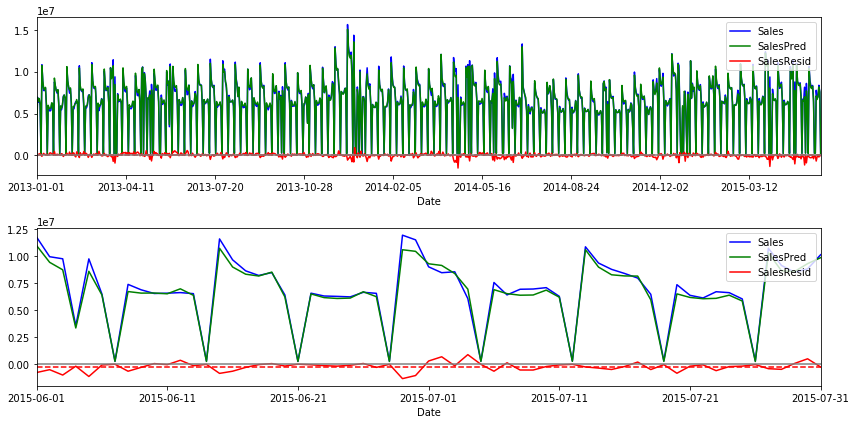

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_true_and_pred_sales(ax1, df_train_start)
plot_true_and_pred_sales(ax2, df_val)
fig.tight_layout()

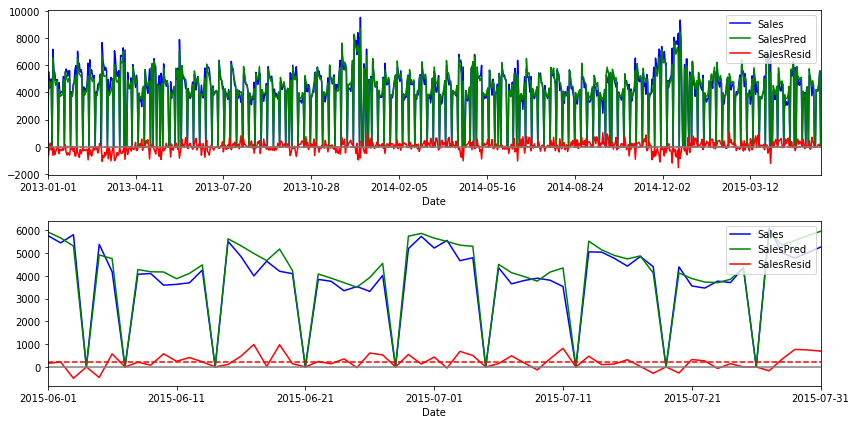

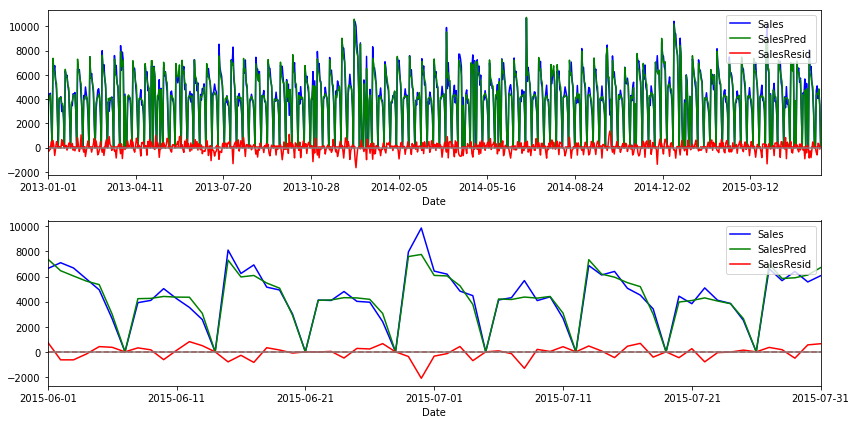

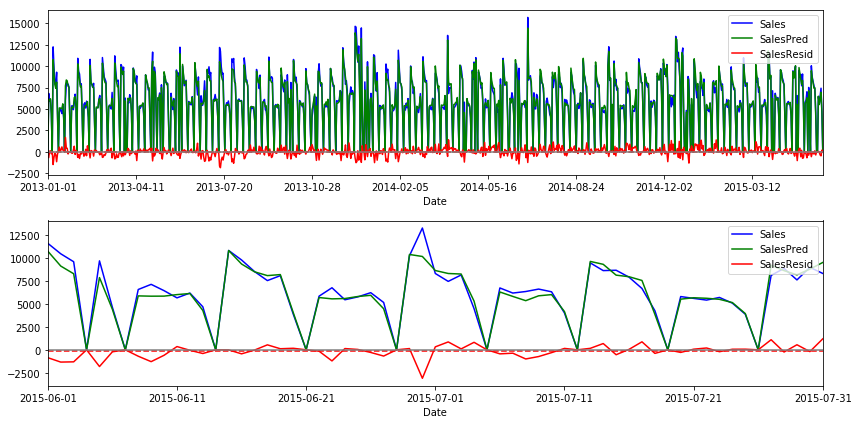

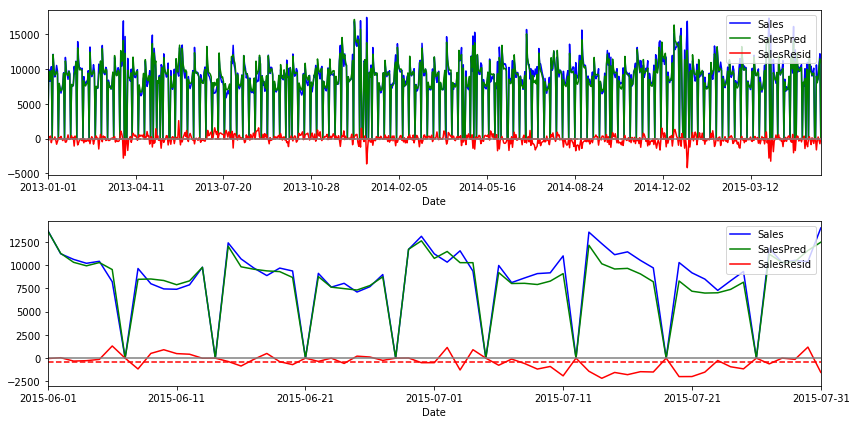

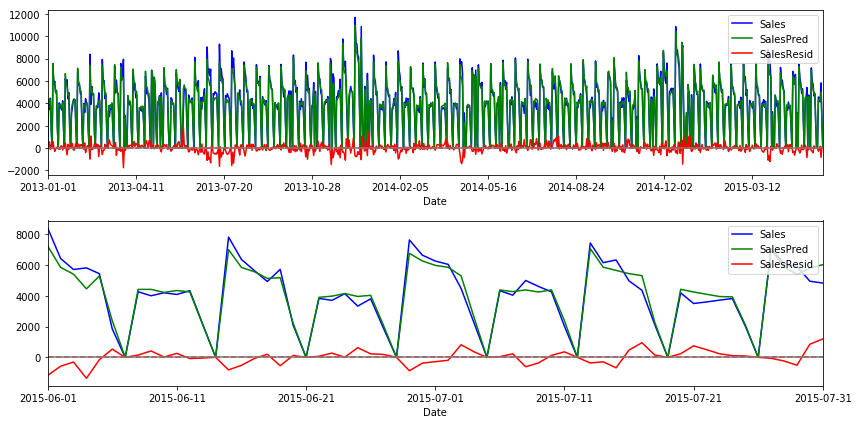

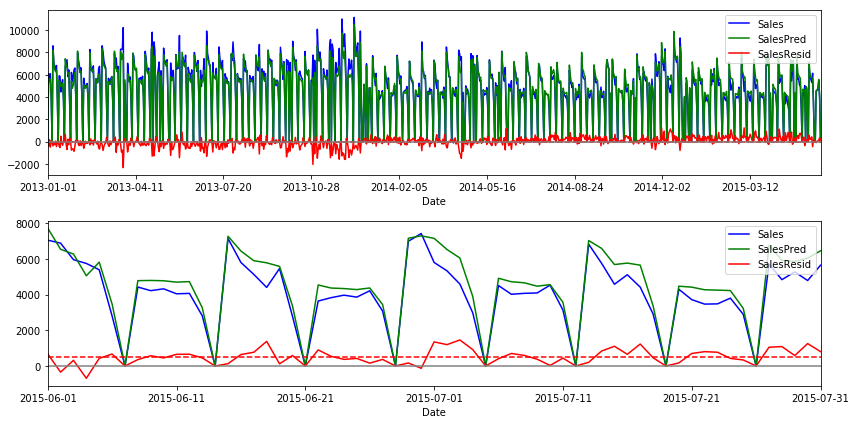

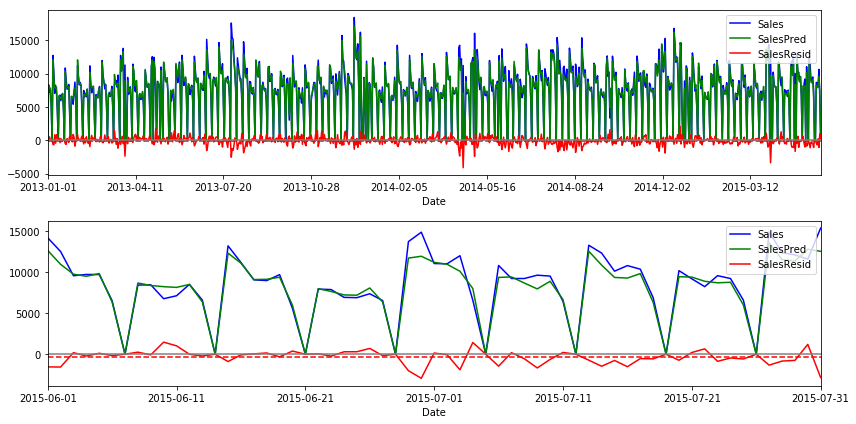

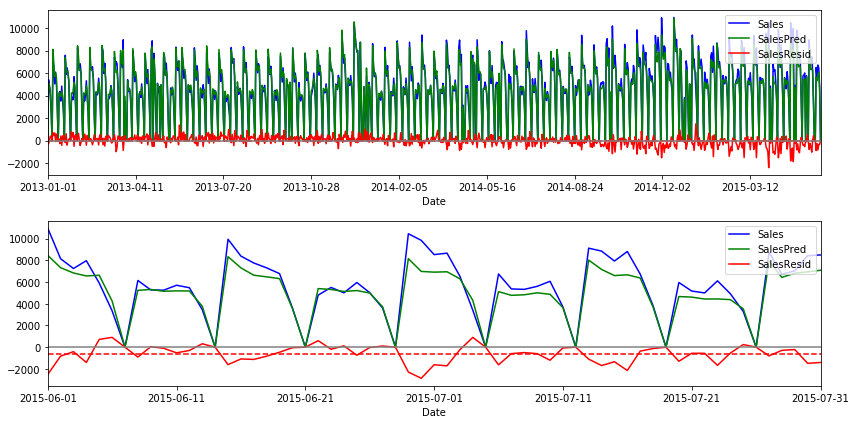

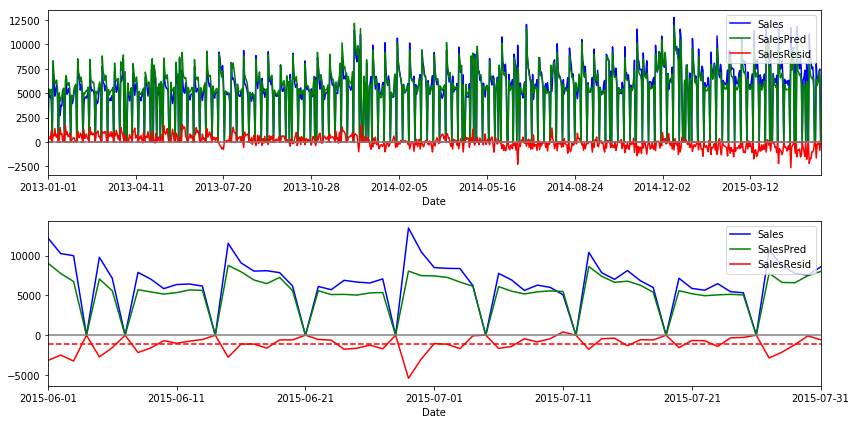

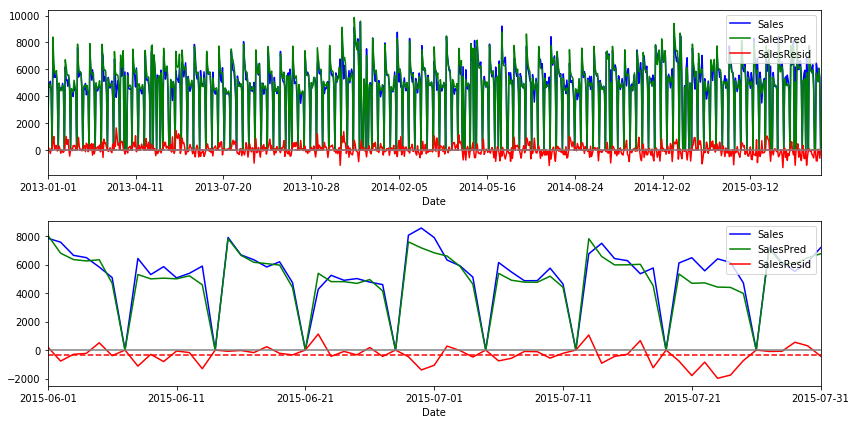

In [44]:
for storeid in range(1, 11):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    df = df_train_start[df_train_start['Store']==storeid]
    plot_true_and_pred_sales(ax1, df)

    df = df_val[df_val['Store']==storeid]
    plot_true_and_pred_sales(ax2, df)
    
    fig.tight_layout()

# Use the chosen hyperparameters and retrain on the entire training set

In [182]:
X_train = df_train[features].values
y_train = df_train[target].values

X_test = df_test[features].values

In [27]:
n_estimators=20
min_samples_split = 2
max_depth = 30
min_samples_leaf = 2

reg = ensemble.RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
    max_features='sqrt', 
    n_jobs=-1, random_state=1)

reg.fit(X_train, y_train)

# Make predictions
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Compare to true values
err_train = calculate_rmspe(y_train, y_train_pred)
print err_train

0.14275841290109775


In [28]:
df_test['Sales'] = y_test_pred
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,Sales
0,1,1,4,2015-09-17,1.0,1,0,1270.0,9.0,2008.0,...,1,0,1,0,0,1,0,0,0,4550.588125
1,857,1,3,2015-09-16,1.0,1,0,1270.0,9.0,2008.0,...,1,0,1,0,0,1,0,0,0,4712.636090
2,1713,1,2,2015-09-15,1.0,1,0,1270.0,9.0,2008.0,...,1,0,1,0,0,1,0,0,0,5059.064812
3,2569,1,1,2015-09-14,1.0,1,0,1270.0,9.0,2008.0,...,1,0,1,0,0,1,0,0,0,5339.284104
4,3425,1,7,2015-09-13,0.0,0,0,1270.0,9.0,2008.0,...,1,0,1,0,0,1,0,0,0,0.000000


# Submit the results to Kaggle

In [29]:
df_test_submit = df_test[['Id', 'Sales']]
df_test_submit.head()

,Id,Sales
0,1,4550.588125
1,857,4712.636090
2,1713,5059.064812
3,2569,5339.284104
4,3425,0.000000


In [30]:
df_test_submit = df_test_submit.sort_values('Id')
df_test_submit.head()

,Id,Sales
0,1,4550.588125
48,2,7955.979861
96,3,8751.439704
144,4,6257.229342
192,5,6361.635791


In [31]:
df_test_submit.to_csv('submit.csv', index=False)

In [32]:
df_test_submit.shape

(41088, 2)

In [34]:
# Predicted score from validation set: 0.1366
# Actual Kaggle score for test set: 0.1351
# 1st place score: 0.10021
# place: 1831 out of 3303
1831/3303.

0.5543445352709658